In [24]:
from google.colab import drive

In [25]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [26]:
import io
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# sklearn models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# sklearn tools
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Statistical packages
import statsmodels.api as sm
from statsmodels.formula.api import ols   # ordinary least squares model
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [38]:
df = pd.read_csv('/content/drive/MyDrive/THESIS_MACHINE_LEARNING/Revised_Data.csv')
df

,Cpds,LogKow,Electron C2,Electron N,Molecular Weight
0,DPA2,3.50,0.324,-0.702,169
1,DM-AD2,4.14,0.270,-0.676,209
2,IPDM-AD2,5.59,0.269,-0.677,251
3,DIP-DPA2,6.20,0.323,-0.706,253
4,DIPDM-AD2,7.05,0.264,-0.678,293
5,DPPD2,3.30,0.217,-0.705,260
6,PTPD2,3.90,0.288,-0.671,274
7,DTPD2,4.60,0.285,-0.671,288
8,TO-DPA2,7.05,0.327,-0.707,281
9,TOS-DPA2,9.21,0.330,-0.710,385


In [39]:
# Assuming X contains your features and df contains your data
# Define X as the features
X = df.iloc[:, 2:]  # Assuming your features start from the third column, adjust accordingly if needed
print("X (Features):\n", X)

# Filter out the rows corresponding to IP-DPA, S-DPA, and DTO-DPA for the test data
test_indices = [11, 12, 13]
test = df.loc[test_indices]
print("\nTest Data (Rows 11, 12, 13):\n", test)

train_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train = df.loc[train_indices]
print("\nTrain Data (Rows 0-10):\n", train)

# Select rows for train set
X_train = X.iloc[train_indices]
print("\nX_train (Features for Training):\n", X_train)

# Select rows for test set
X_test = X.iloc[test_indices]
print("\nX_test (Features for Test):\n", X_test)

# Extracting target and features for training data
y_train = train.iloc[:, 1]
X_train = train.iloc[:, 2:]  # Uncomment if you're using X_train
print("\ny_train (Target for Training):\n", y_train)
print("\nX_train (Features for Training):\n", X_train)

# Extracting target and features for test data
y_vset = test.iloc[:, 1]
X_vset = test.iloc[:, 2:]
print("\ny_vset (Target for Test):\n", y_vset)
print("\nX_vset (Features for Test):\n", X_vset)


X (Features):
     Electron C2  Electron N  Molecular Weight
0         0.324      -0.702               169
1         0.270      -0.676               209
2         0.269      -0.677               251
3         0.323      -0.706               253
4         0.264      -0.678               293
5         0.217      -0.705               260
6         0.288      -0.671               274
7         0.285      -0.671               288
8         0.327      -0.707               281
9         0.330      -0.710               385
10        0.325      -0.710               479
11        0.321      -0.704               211
12        0.326      -0.705               273
13        0.330      -0.711               293

Test Data (Rows 11, 12, 13):
         Cpds  LogKow  Electron C2  Electron N  Molecular Weight
11   IP-DPA2    4.75        0.321      -0.704               211
12    S-DPA2    5.45        0.326      -0.705               273
13  DTO-DPA2   10.33        0.330      -0.711               293

Train D

In [44]:
y_train = train.iloc[:,1]
X_train = train.iloc[:,2:]

y_test = test.iloc[:,1]
X_test = test.iloc[:,2:]

In [41]:
pip install optuna

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)

    # Define the model with suggested hyperparameters
    model = RandomForestRegressor(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )

    # Fit the model on the training set
    model.fit(X_train, y_train)

    # Predict on the training set
    y_train_pred = model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

    # Predict on the test set
    y_test_pred = model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

    # Combine RMSE for training and test sets
    combined_rmse = train_rmse + test_rmse  # Minimize the sum of both
    return combined_rmse

# Create an Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, timeout=600)  # 100 trials or 10 minutes timeout

# Best hyperparameters
best_params = study.best_params
print("Best parameters:", best_params)

# Fit the model with the best parameters
best_model = RandomForestRegressor(
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    min_samples_split=best_params["min_samples_split"],
    n_estimators=best_params["n_estimators"],
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)




In [127]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the model with the provided parameters
best_model = RandomForestRegressor(
    max_depth=5,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=224,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Fit the model on the training set
best_model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = best_model.predict(X_train)

# Predictions on the test set
y_test_pred = best_model.predict(X_test)

# Evaluate the model on the training set
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)

# Evaluate the model on the test set
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print("Model Evaluation with Provided Parameters:")
print(f"Training RMSE: {train_rmse:.3f}, Training R²: {train_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}, Test R²: {test_r2:.3f}")


Model Evaluation with Provided Parameters:
Training RMSE: 0.758, Training R²: 0.925
Test RMSE: 0.765, Test R²: 0.905


In [130]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np

# Convert X_train and y_train to NumPy arrays
X_train_np = X_train.values if hasattr(X_train, "values") else X_train
y_train_np = y_train.values if hasattr(y_train, "values") else y_train

# Initialize K-Fold Cross-Validation
n_splits = 5  # Specify the number of splits
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# List to store R² scores for each fold
r2_scores = []

# Perform Cross-Validation
for train_index, test_index in kf.split(X_train_np):
    # Split the data into training and validation folds
    X_cv_train, X_cv_test = X_train_np[train_index], X_train_np[test_index]
    y_cv_train, y_cv_test = y_train_np[train_index], y_train_np[test_index]

    # Use the existing model to predict on the validation fold
    y_pred = best_model.predict(X_cv_test)

    # Calculate R² score for the validation fold
    r2_fold = r2_score(y_cv_test, y_pred)
    r2_scores.append(r2_fold)

# Calculate Mean and Standard Deviation of R² Scores
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

# Display Results
print(f"Mean R² (Cross-Validation): {mean_r2:.4f} ± {std_r2:.4f}")

Mean R² (Cross-Validation): 0.8725 ± 0.0788


In [131]:
# Print predicted data for train set
print("Predicted data for train set:")
print(y_train_pred)

# Print predicted data for test set
print("\nPredicted data for test set:")
print(y_test_pred)


Predicted data for train set:
[ 4.29855655  4.46165625  5.16915179  5.65200893  6.26022321  4.371875
  4.17290625  5.02086756  6.91482143  9.72580357 11.29955357]

Predicted data for test set:
[4.6925     5.42785714 9.00616071]


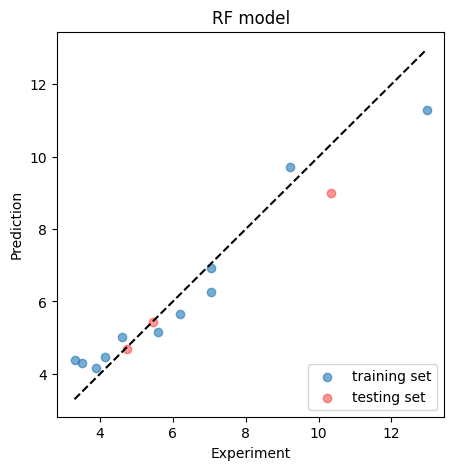

In [128]:
# Data visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(11,5))

# 1 row, 2 columns, plot 1
plt.subplot(1, 2, 1)
plt.scatter(x=y_train, y=y_train_pred, alpha=0.6, label="training set")
plt.scatter(x=y_test, y=y_test_pred, c="Red", alpha=0.4, label="testing set")
plt.legend(loc="lower right")

# Line representing ideal prediction
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], "--", color="Black")

# Customize plot
plt.title('RF model')
plt.ylabel('Prediction')
plt.xlabel('Experiment')

# Save the figure as an SVG file
plt.savefig("RF.svg", format='svg')

# Show plot (optional)
plt.show()
